In [1]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

% matplotlib inline

In [58]:
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    tensor = torch.LongTensor(idxs)
    return autograd.Variable(tensor)


training_data = [
    ("The dog ate the apple".split(), ["DET", "NN", "V", "DET", "NN"]),
    ("Everybody read that book".split(), ["NN", "V", "DET", "NN"])
]
word_to_ix = {}
for sent, tags in training_data:
    for word in sent:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)
print(word_to_ix)
tag_to_ix = {"DET": 0, "NN": 1, "V": 2}

# These will usually be more like 32 or 64 dimensional.
# We will keep them small, so we can see how the weights change as we train.
EMBEDDING_DIM = 6
HIDDEN_DIM = 6

{'The': 0, 'dog': 1, 'ate': 2, 'the': 3, 'apple': 4, 'Everybody': 5, 'read': 6, 'that': 7, 'book': 8}


In [62]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)
        self.hidden = self.init_hidden()

    def init_hidden(self):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly
        # why they have this dimensionality.
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        return (autograd.Variable(torch.zeros(1, 1, self.hidden_dim)),
                autograd.Variable(torch.zeros(1, 1, self.hidden_dim)))

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, self.hidden = self.lstm(
            embeds.view(len(sentence), 1, -1), self.hidden)
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
#         print("_LKSJF = ", tag_space)
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores


In [68]:
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix))
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

# See what the scores are before training
# Note that element i,j of the output is the score for tag j for word i.
inputs = prepare_sequence(training_data[0][0], word_to_ix)
tag_scores = model(inputs)
# print(tag_scores)
loss_save = []
for epoch in range(300):  # again, normally you would NOT do 300 epochs, it is toy data
    for sentence, tags in training_data:
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Also, we need to clear out the hidden state of the LSTM,
        # detaching it from its history on the last instance.
        model.hidden = model.init_hidden()

        # Step 2. Get our inputs ready for the network, that is, turn them into
        # Variables of word indices.
        sentence_in = prepare_sequence(sentence, word_to_ix)
        targets = prepare_sequence(tags, tag_to_ix)
#         print(sentence_in)
#         print(targets)
        # Step 3. Run our forward pass.
        tag_scores = model(sentence_in)
#         print(tag_scores,targets)
        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = loss_function(tag_scores, targets)
        loss_save.append(loss.data.numpy())
        loss.backward()
        optimizer.step()

# See what the scores are after training
inputs = prepare_sequence(training_data[0][0], word_to_ix)
tag_scores = model(inputs)
# The sentence is "the dog ate the apple".  i,j corresponds to score for tag j
#  for word i. The predicted tag is the maximum scoring tag.
# Here, we can see the predicted sequence below is 0 1 2 0 1
# since 0 is index of the maximum value of row 1,
# 1 is the index of maximum value of row 2, etc.
# Which is DET NOUN VERB DET NOUN, the correct sequence!
print(tag_scores)

Variable containing:
-0.1965 -1.7928 -4.4343
-3.4248 -0.0360 -5.8818
-3.8921 -4.4297 -0.0329
-0.0317 -3.7988 -4.7365
-3.6696 -0.0271 -6.6506
[torch.FloatTensor of size 5x3]



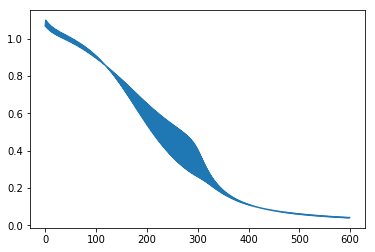

In [69]:
plt.plot(loss_save)

In [ ]:
word_dict = {0:"Doug ", 1:"Judy ", 2:"Brad ", 3:"saw ", 4:". "}

In [ ]:
vocab_size = len(word_dict)

In [ ]:
sentences = torch.LongTensor([0,3,1,4])
print(sentences)

In [102]:
# def prepare_sequence(seq, to_ix):
#     idxs = [to_ix[w] for w in seq]
#     tensor = torch.LongTensor(idxs)
#     return autograd.Variable(tensor)
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    tensor = torch.LongTensor(idxs)
    return autograd.Variable(tensor)

training_data = [
    ("Doug saw Judy".split(), [0,1,2], "saw Judy .".split(), [1,2,3]),
    ("saw Judy .".split(), [1,2,3], "Judy . Judy".split(), [2,3,2]),
    ("Judy . Judy".split(), [2,3,2], ". Judy saw".split(), [3,2,1]),
    (". Judy saw".split(), [3,2,1], "Judy saw Brad".split(), [2,1,4]),
    ("Judy saw Brad".split(), [2,1,4], "saw Brad .".split(), [1,4,3]),
    ("saw Brad .".split(), [1,4,3], "Brad . Brad".split(), [4,3,4]),
    ("Brad . Brad".split(), [4,3,4], ". Brad saw".split(), [3,4,1]),
    (". Brad saw".split(), [3,4,1], "Brad saw Doug".split(), [4,1,0]),
    ("Brad saw Doug".split(), [4,1,0], "saw Doug .".split(), [1,0,3]),
    ("saw Doug .".split(), [1,0,3], "Doug . Doug".split(), [0,3,0]),
    ("Doug . Doug".split(), [0,3,0], ". Doug saw".split(), [3,0,1]),
    (". Doug saw".split(), [3,0,1], "Doug saw Judy".split(), [0,1,2])
]
word_to_ix = {}
for inp, t_in, out, t_out in training_data:
    for word in inp:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)
print(word_to_ix)
tag_to_ix = {'Doug': 0, 'saw': 1, 'Judy': 2, '.': 3, 'Brad': 4}
output_dict = {0:'Doug', 1:'saw', 2:'Judy', 3:'.', 4:'Brad'}
# These will usually be more like 32 or 64 dimensional.
# We will keep them small, so we can see how the weights change as we train.
EMBEDDING_DIM = 6
HIDDEN_DIM = 6

{'Doug': 0, 'saw': 1, 'Judy': 2, '.': 3, 'Brad': 4}


'Doug'

In [124]:
INPUT_SIZE = 6
OUTPUT_SIZE = 6
LAYER_SIZE = 2
BATCH_SIZE = 1

class CBLSTM(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(CBLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.word_embeddings = nn.Embedding(vocab_size, INPUT_SIZE)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(INPUT_SIZE, OUTPUT_SIZE, LAYER_SIZE)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(OUTPUT_SIZE, tagset_size)
        self.hidden = self.init_hidden()

    def init_hidden(self):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly
        # why they have this dimensionality.
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        return (autograd.Variable(torch.zeros(LAYER_SIZE, BATCH_SIZE, OUTPUT_SIZE)),
                autograd.Variable(torch.zeros(LAYER_SIZE, BATCH_SIZE, OUTPUT_SIZE)))

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence) # embed the sentence e.g. [0,1,2] to 3x6 (3 words, 6 embed size)
        lstm_out, self.hidden = self.lstm(
            embeds.view(len(sentence), 1, -1), self.hidden)
#         print("OUT = ", lstm_out)
#         print("HID = ", self.hidden)
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
#         print(tag_space)
#         _, out = tag_space.max(dim=1)
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

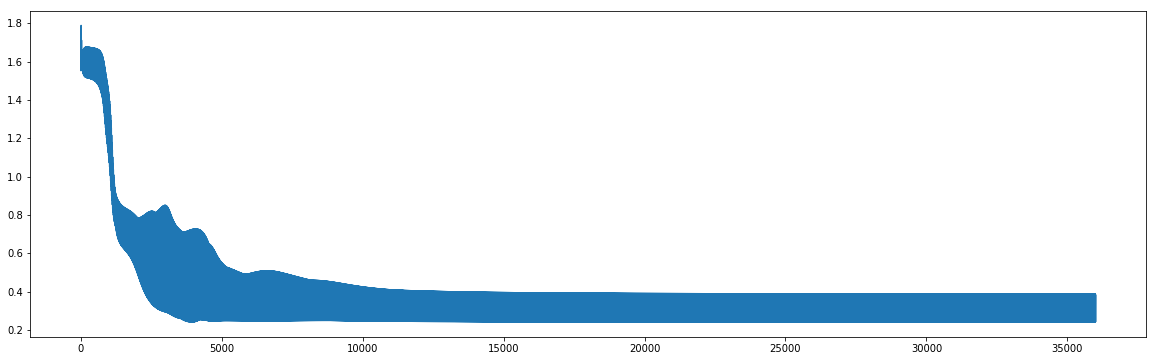

In [125]:
model = CBLSTM(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix))
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)
inputs = autograd.Variable(torch.LongTensor(training_data[0][1]))
target = autograd.Variable(torch.LongTensor(training_data[0][3]))
tag_scores = model(inputs)
# print(tag_scores)
flag = 0
loss_save = []
for epoch in range(3000):  # again, normally you would NOT do 300 epochs, it is toy data
#     print("EPOCH = ", epoch)
    for sentence, _, tags, _ in training_data:
        model.zero_grad()
        model.hidden = model.init_hidden()
        sentence_in = prepare_sequence(sentence, word_to_ix)
        targets = prepare_sequence(tags, tag_to_ix)
        tag_scores = model(sentence_in)
        loss = loss_function(tag_scores, targets)
        loss_save.append(loss.data[0])
        loss.backward()
        optimizer.step()

plt.figure(figsize=[20,6])
plt.plot(loss_save)
# plt.xlim([0,50])
plt.show()


In [139]:
childrenbook = []
inputs = prepare_sequence(training_data[9][0], word_to_ix)
for i in range(100):
    tag_scores = model(inputs)
    _, out = tag_scores[-1:,:].max(dim = 1)
    childrenbook.append(output_dict[int(out.data.numpy())])
#     print(inputs)
    inputs = inputs[1:]
#     print(inputs)
    nextin = autograd.Variable(torch.LongTensor([tag_to_ix[output_dict[int(out.data.numpy())]]]))
    inputs = torch.cat((inputs, nextin))

print(childrenbook)
#     print(inputs)
# The sentence is "the dog ate the apple".  i,j corresponds to score for tag j
#  for word i. The predicted tag is the maximum scoring tag.
# Here, we can see the predicted sequence below is 0 1 2 0 1
# since 0 is index of the maximum value of row 1,
# 1 is the index of maximum value of row 2, etc.
# Which is DET NOUN VERB DET NOUN, the correct sequence!
# print(tag_scores)

['Doug', 'saw', 'Judy', '.', 'Judy', 'saw', 'Brad', '.', 'Brad', 'saw', 'Doug', '.', 'Doug', 'saw', 'Judy', '.', 'Judy', 'saw', 'Brad', '.', 'Brad', 'saw', 'Doug', '.', 'Doug', 'saw', 'Judy', '.', 'Judy', 'saw', 'Brad', '.', 'Brad', 'saw', 'Doug', '.', 'Doug', 'saw', 'Judy', '.', 'Judy', 'saw', 'Brad', '.', 'Brad', 'saw', 'Doug', '.', 'Doug', 'saw', 'Judy', '.', 'Judy', 'saw', 'Brad', '.', 'Brad', 'saw', 'Doug', '.', 'Doug', 'saw', 'Judy', '.', 'Judy', 'saw', 'Brad', '.', 'Brad', 'saw', 'Doug', '.', 'Doug', 'saw', 'Judy', '.', 'Judy', 'saw', 'Brad', '.', 'Brad', 'saw', 'Doug', '.', 'Doug', 'saw', 'Judy', '.', 'Judy', 'saw', 'Brad', '.', 'Brad', 'saw', 'Doug', '.', 'Doug', 'saw', 'Judy', '.']


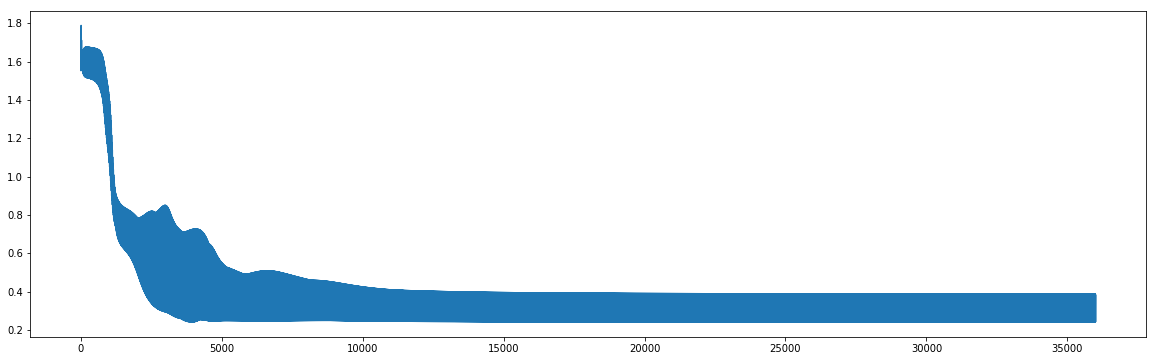

In [133]:
plt.figure(figsize=[20,6])
plt.plot(loss_save)
# plt.xlim([0,50])
plt.show()

In [ ]:
test = nn.Embedding(vocab_size, 10)



In [ ]:
print(test)
print(targets)
F.cross_entropy(test,targets)